In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 10
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2012-04-10', datetime.date(2022, 4, 10))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


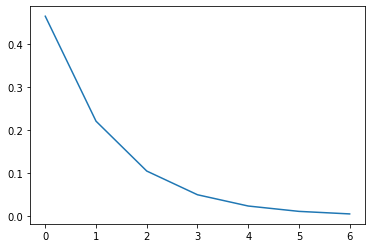

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-04  20.751611  8.175625  20.751611  8.175625  20.751611  8.175625   
2022-04-05  20.011166  7.902315  20.011166  7.902315  20.011166  7.902315   
2022-04-06  19.281924  7.588986  19.281924  7.588986  19.281924  7.588986   
2022-04-07  19.160761  7.575626  19.160761  7.575626  19.160761  7.575626   
2022-04-08  18.732501  7.354080  18.732501  7.354080  18.732501  7.354080   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-04  20.751611  8.175625  20.751611  8.175625  
2022-04-05  20.011166  7.902315  20.011166  7.902315  
2022-04-06  19.281924  7.588986  19.281924  7.588986  
2022-04-07  19.160761  7.575626  19.160761  7.575626  
2022-04-08  18.732501  7.354080  18.732501  7.354080

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                                Close  \
         ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
0  1358.589966  2991.219971  7841.910156  14245.500000  1358.589966   
1  1368.709961  3016.459961  7912.850098  14366.589844  1368.709961   
2  1387.569946  3055.550049  8039.950195  14574.259766  1387.569946   
3  1370.260010  3011.330078  7931.089844  14398.240234  1370.260010   
4  1369.569946  2988.399902  7949.560059  14386.580078  1369.569946   

                                                  High               ...  \
         ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC  ...   
0  2991.219971  7841.910156  14245.500000  1383.010010  3055.199951  ...   
1  3016.459961  7912.850098  14366.589844  1374.709961  3030.510010  ...   
2  3055.550049  8039.950195  14574.259766  1388.130005  3059.260010  ...   
3  3011.330078  7931.089844  14398.240234  1387.609985  3045.419922  ...   
4  2988.399902  7949.560059  14386.580078  1379.660034  3027.570068  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN -0.020062            1.0            NaN   
1       1.008500             1.0 -0.007183            1.0       1.012962   
2       1.014455             1.0  0.006624            1.0       1.013903   
3       0.987923             1.0 -0.005045            1.0       0.988398   
4       0.999190             1.0 -0.017959            1.0       0.987169   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN -0.020062            1.0            NaN             NaN  
1        1.012962 -0.007255            1.0       1.012889        1.012889  
2        1.013903  0.006488            1.0       1.013838        1.013838  
3        0.988398 -0.005286            1.0       0.988295        0.988295  
4        0.987169 -0.018029            1.0       0.987338        0.987338  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2513   2022-04-04
2514   2022-04-05
2515   2022-04-06
2516   2022-04-07
2517   2022-04-08
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                                Close  \
                  ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
Date                                                                           
2012-04-10  1358.589966  2991.219971  7841.910156  14245.500000  1358.589966   
2012-04-11  1368.709961  3016.459961  7912.850098  14366.589844  1368.709961   
2012-04-12  1387.569946  3055.550049  8039.950195  14574.259766  1387.569946   
2012-04-13  1370.260010  3011.330078  7931.089844  14398.240234  1370.260010   
2012-04-16  1369.569946  2988.399902  7949.560059  14386.580078  1369.569946   

                                                           High               \
                  ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC   
Date                                                                           
2012-04-10  2991.219971  7841.910156  14245.500000  1383.010010  3055.199951   
2012-04-11  3016.459961  7912.850098  14366.589844  1374.709961  3030.510010   
2012-04-12  3055.550049  8039.950195  14574.259766  1388.130005  3059.260010   
2012-04-13  3011.330078  7931.089844  14398.240234  1387.609985  3045.419922   
2012-04-16  2988.399902  7949.560059  14386.580078  1379.660034  3027.570068   

            ... DayToDayChange OvernightChange  LogValue IntradayChange  \
            ...         ^W5000          ^W5000     mine1          mine1   
Date        ...                                                           
2012-04-10  ...            NaN             NaN -0.020062            1.0   
2012-04-11  ...       1.008500             1.0 -0.007183            1.0   
2012-04-12  ...       1.014455             1.0  0.006624            1.0   
2012-04-13  ...       0.987923             1.0 -0.005045            1.0   
2012-04-16  ...       0.999190             1.0 -0.017959            1.0   

           DayToDayChange OvernightChange  LogValue IntradayChange  \
                    mine1           mine1     mine2          mine2   
Date                                                                 
2012-04-10            NaN             NaN -0.020062            1.0   
2012-04-11       1.012962        1.012962 -0.007255            1.0   
2012-04-12       1.013903        1.013903  0.006488            1.0   
2012-04-13       0.988398        0.988398 -0.005286            1.0   
2012-04-16       0.987169        0.987169 -0.018029            1.0   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
2012-04-10            NaN             NaN  
2012-04-11       1.012889        1.012889  
2012-04-12       1.013838        1.013838  
2012-04-13       0.988295        0.988295  
2012-04-16       0.987338        0.987338  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.46566128730773904



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.4484910057149456
Refitting current best...
Current best ma returns: 2.6160273291099503
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.4484910057149456
Refitting current best...
Current best ew_ma returns: 2.5743902558429963
Fraction Invested: 0.999656773146526
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.574390696928112
Invested: 0.999656773146526
Round: 90


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 2.4484910057149456
Refi

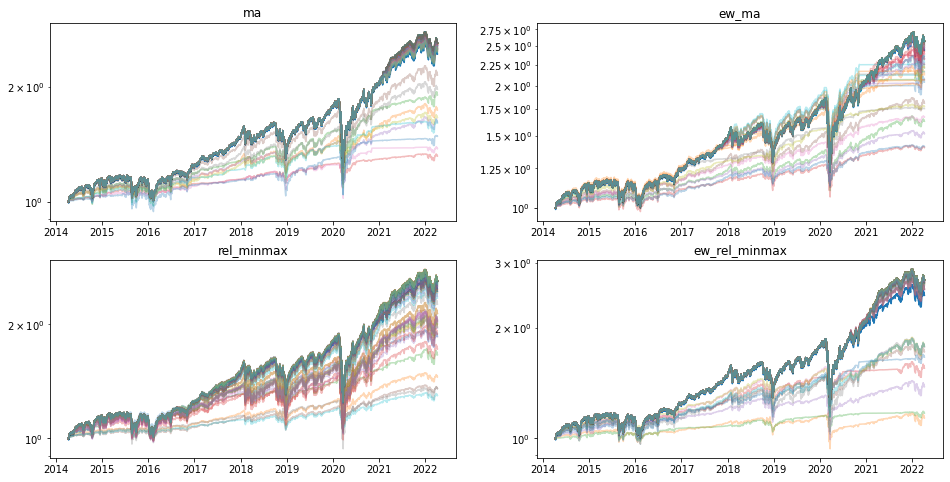

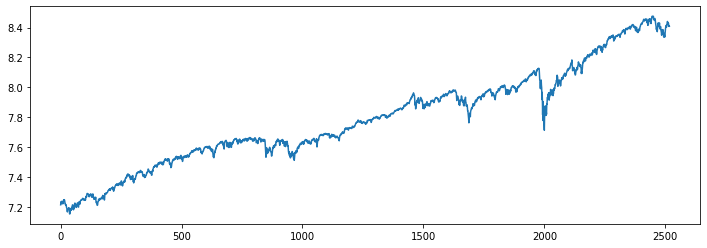

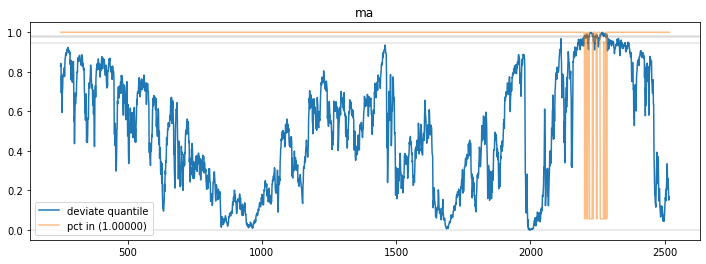

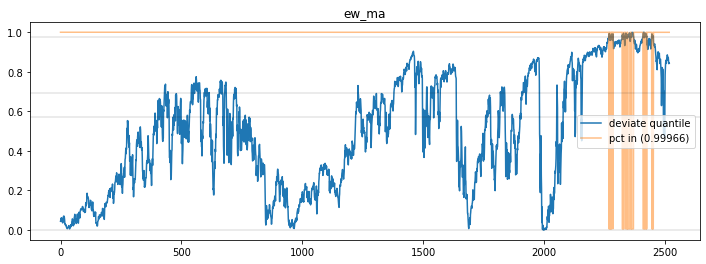

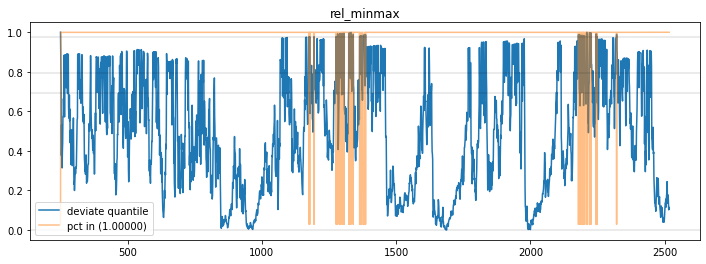

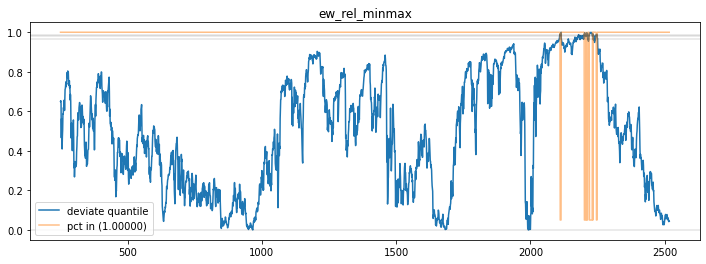

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.3819999054537813
Refitting current best...
Current best ma returns: 3.6844772933089245
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.684515749176056
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.3819999054537813
Refitting current best...
Current best ew_ma returns: 3.7080581614259227
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 3.7082464225935903
Invested: 1.0
New best: 3.7433770172285774
Invested: 1.0
New best: 3.74339037238033
Invested: 1.0
New best: 3.7434685679845847
Invested: 

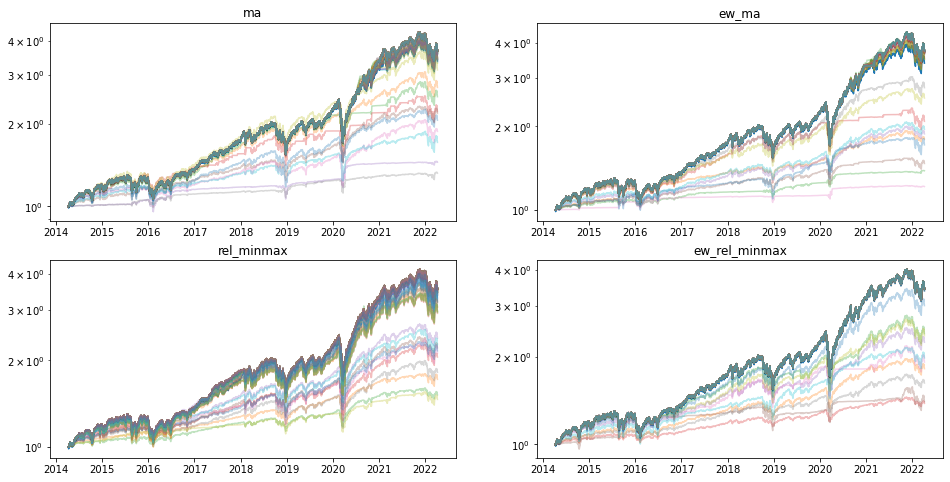

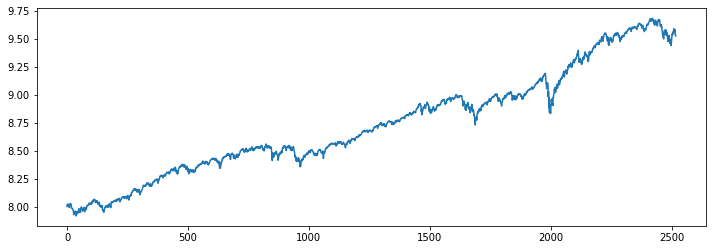

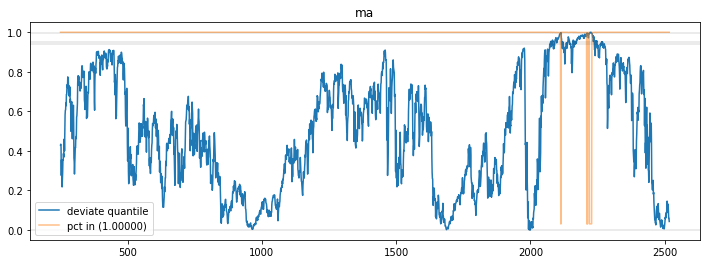

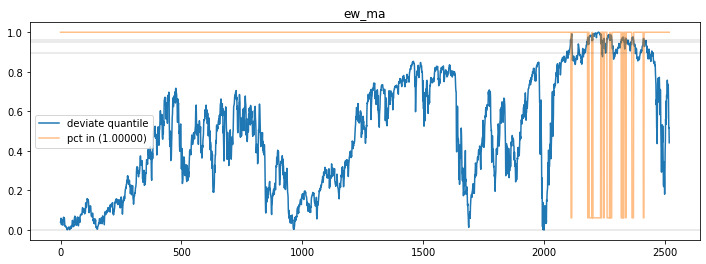

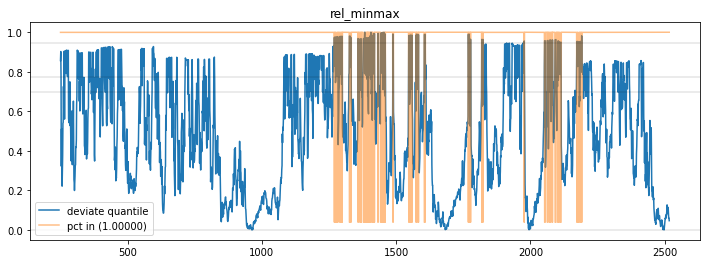

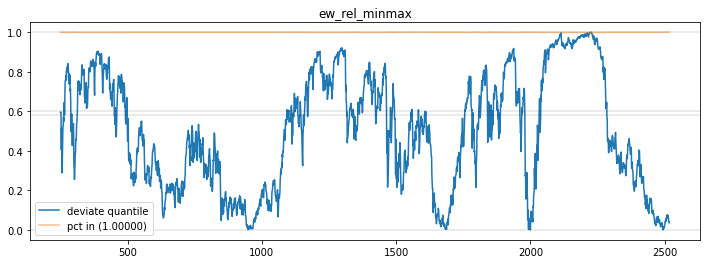

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.6099407542456567
Refitting current best...
Current best ma returns: 1.6233151081491797
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 1.6233159195113227
Invested: 1.0
New best: 1.6233245908740113
Invested: 1.0
New best: 1.6283302974678515
Invested: 1.0
New best: 1.6307418165977325
Invested: 1.0
New best: 1.6346844789995674
Invested: 1.0
New best: 1.6401349858967846
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.6099407542456567
Refitting current best...
Current best ew_ma returns: 1.6426902065249158
Fraction Invested: 0.9999389589249561
Be

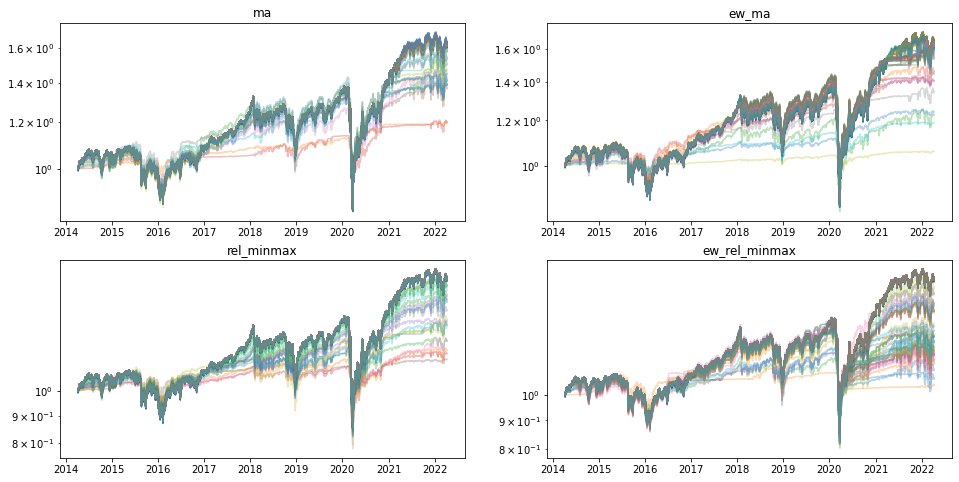

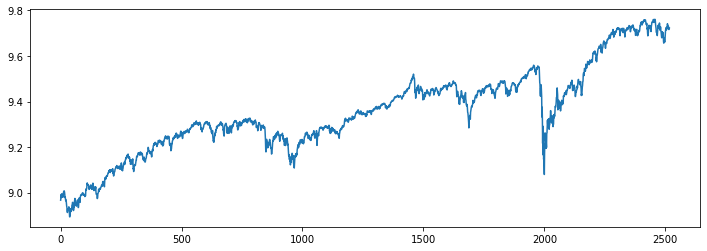

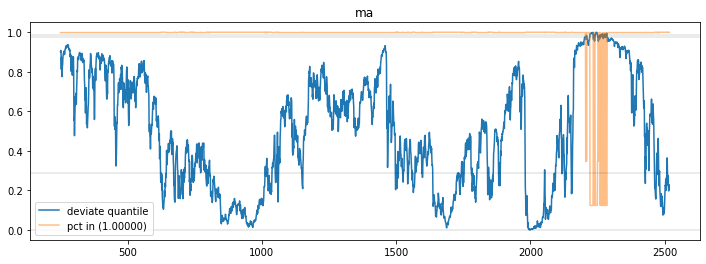

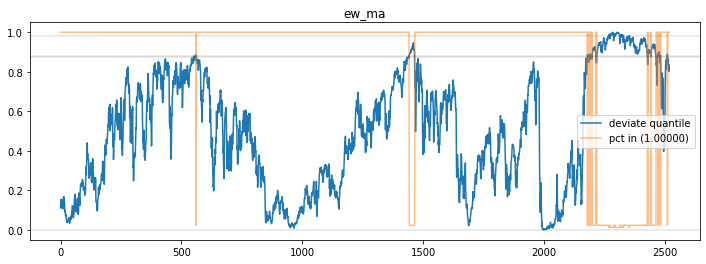

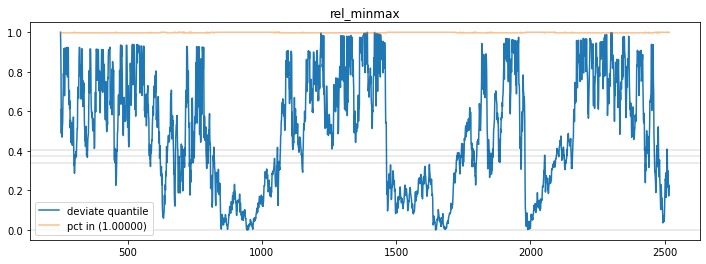

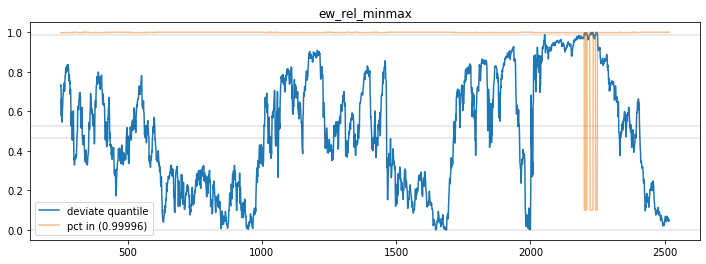

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.301084037461844
Refitting current best...
Current best ma returns: 2.449465576830531
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 2.455716809213647
Invested: 1.0
New best: 2.4715339798471345
Invested: 1.0
New best: 2.4715358041516047
Invested: 1.0
New best: 2.4715388218109076
Invested: 1.0
New best: 2.4715463092637946
Invested: 1.0
New best: 2.489753627953198
Invested: 1.0
New best: 2.4897539859690703
Invested: 1.0
New best: 2.4897542425973924
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.301084037461844
Refitting current best...
Curre

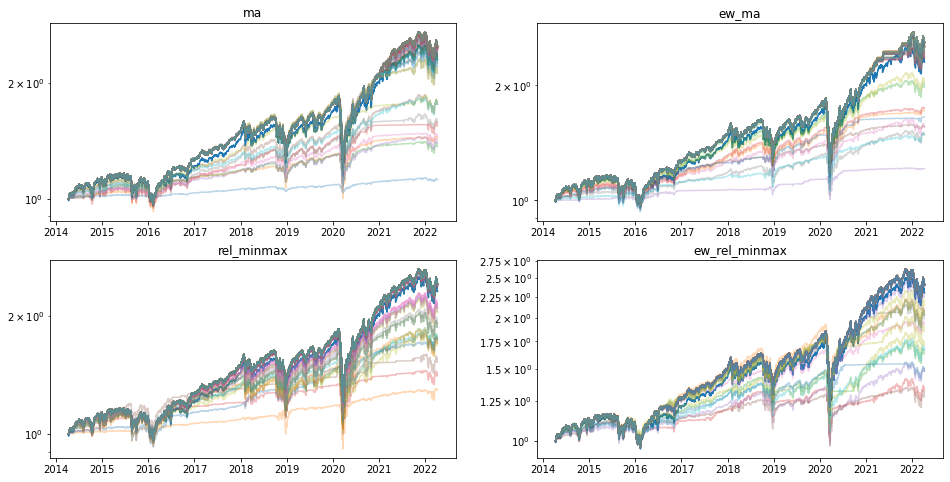

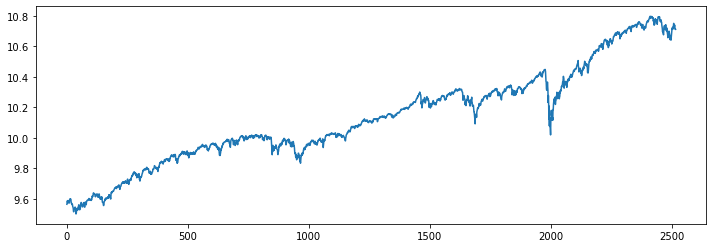

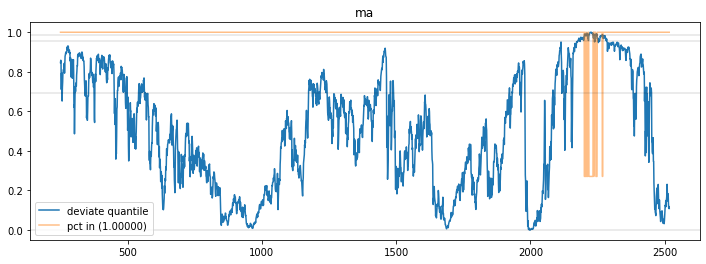

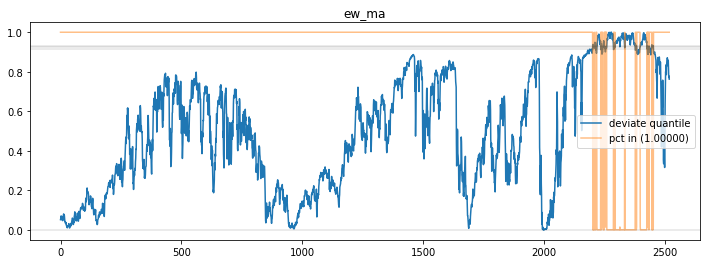

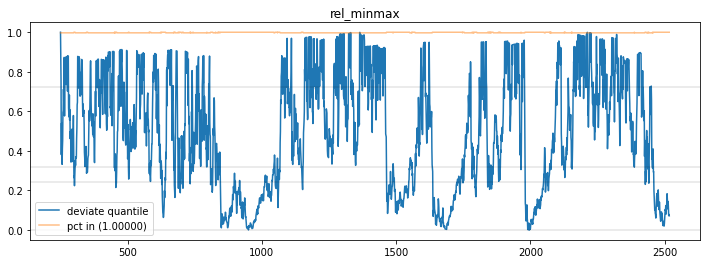

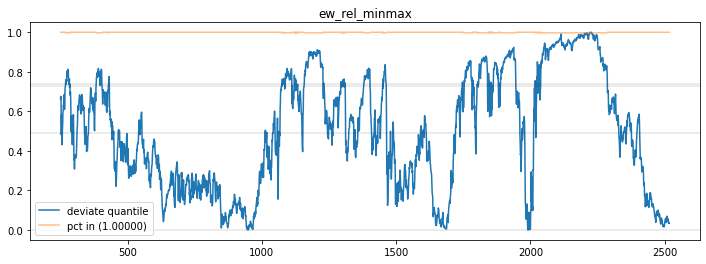

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ma returns: 14.649883123227367
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 13.470615197086508
Refitting current best...
Current best ew_ma returns: 15.55085764641613
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 15.550905473419164
Invested: 1.0
New best: 15.551097136093382
Invested: 1.0
New best: 15.615667398101786
Invested: 1.0
New best: 15.661074043535004
Invested: 1.0
New best: 15.811797589716926
Investe

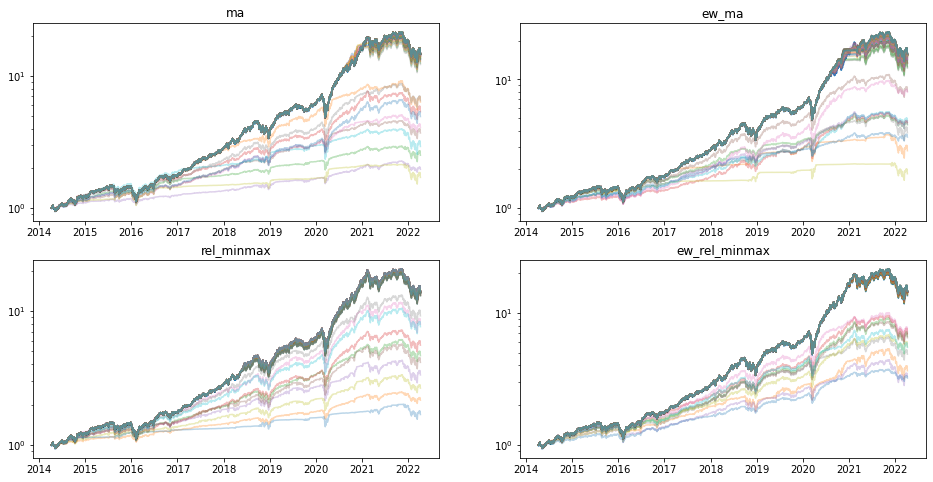

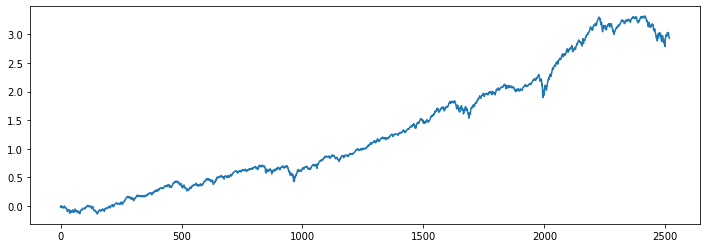

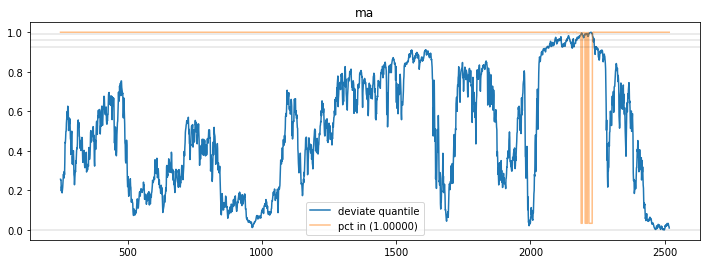

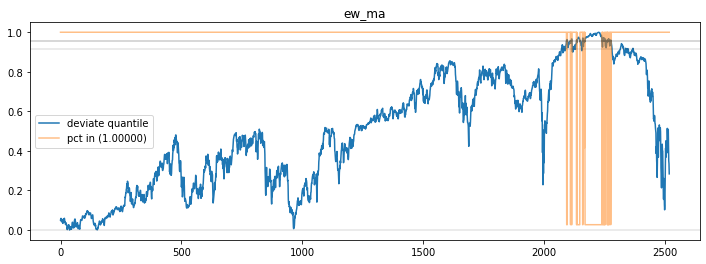

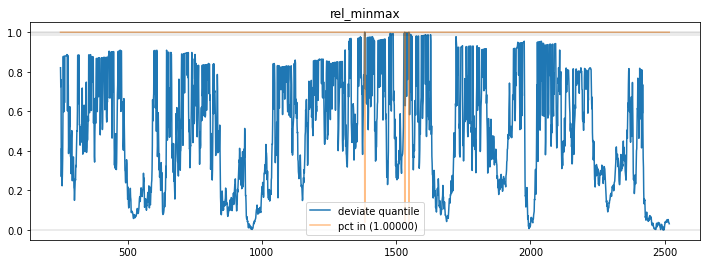

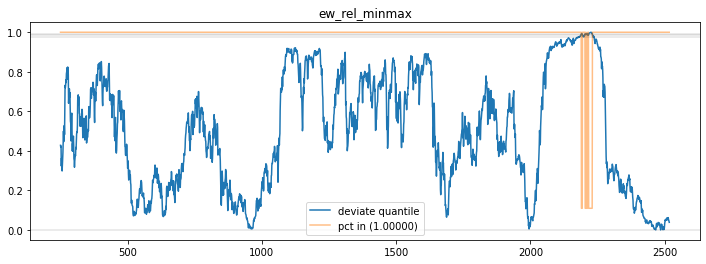

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ma returns: 6.999285444845067
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 6.999321242440068
Invested: 1.0
Round: 90


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 5.293621034351199
Refitting current best...
Current best ew_ma returns: 7.133816847406807
Fraction Invested: 1.0
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 7.133898623941481
Invested: 1.0
Round: 90


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 5.293621034351

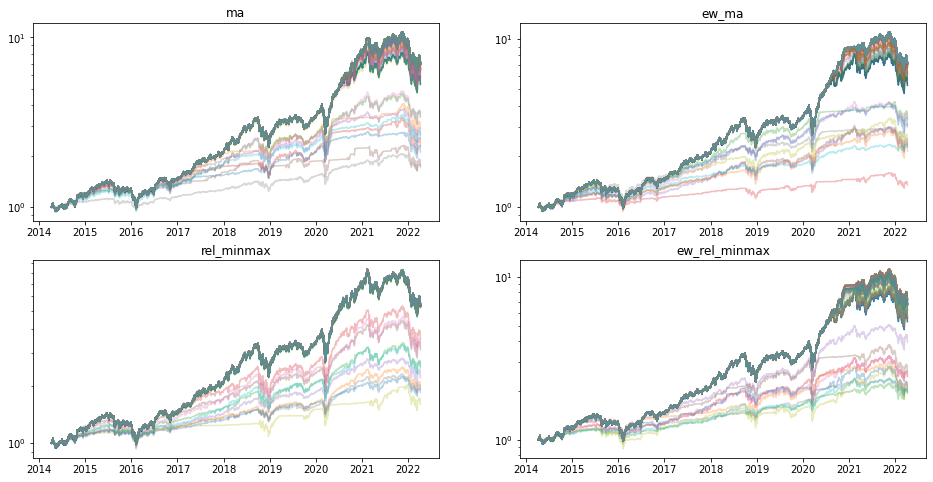

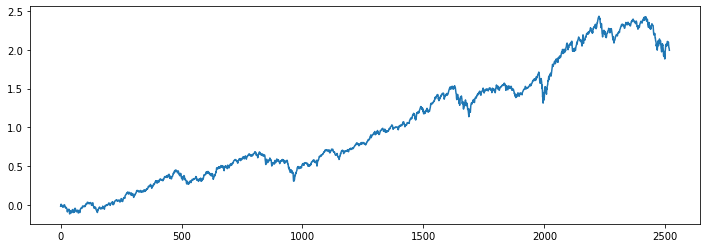

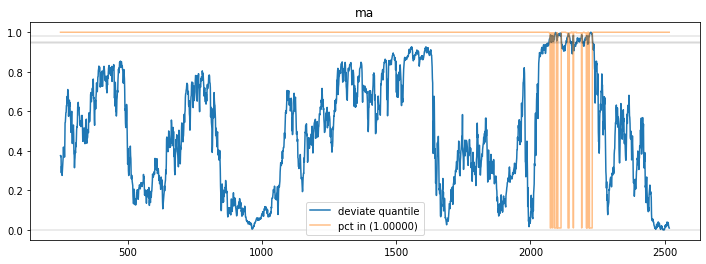

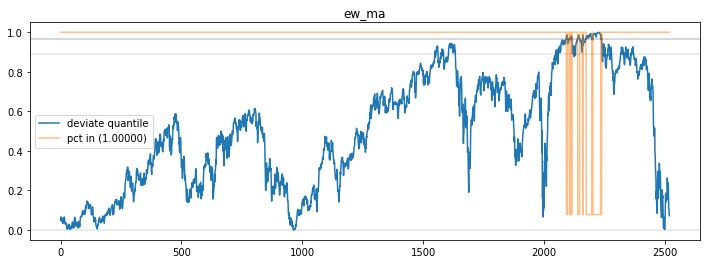

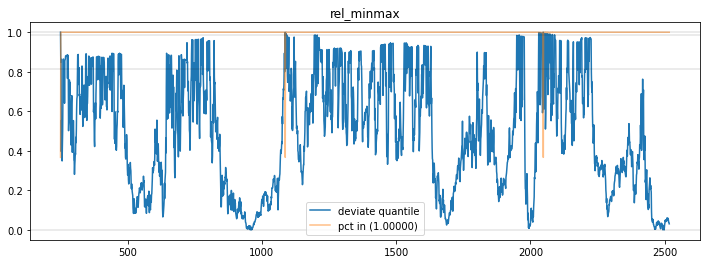

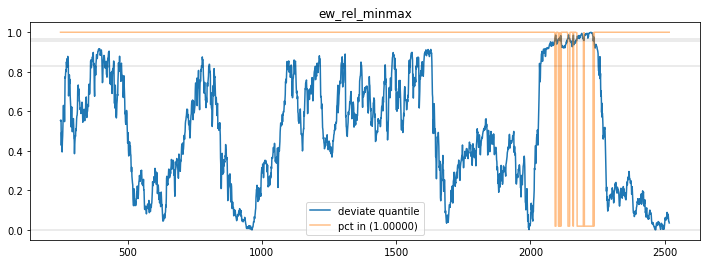

Saving mine2 params...


In [33]:
#N_RAND = 10
#N_ADJ = 90

N_RAND = 5
N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [47]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [48]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 2.6979208132455326 (ew_rel_minmax)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9638): 1.0000
(0.9638 - 0.9808): 1.0000
(0.9808 - 0.9870): 0.9990
(0.9870 - 1.0000): 0.0501

^IXIC:
  Best Return: 3.743935877858648 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.8929): 1.0000
(0.8929 - 0.9528): 1.0000
(0.9528 - 0.9624): 0.9994
(0.9624 - 1.0000): 0.0611

^NYA:
  Best Return: 1.6556359641143532 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.8767): 1.0000
(0.8767 - 0.8823): 1.0000
(0.8823 - 0.9790): 0.0236
(0.9790 - 1.0000): 0.0126

^W5000:
  Best Return: 2.5929953845904503 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9137): 1.0000
(0.9137 - 0.9239): 0.9999
(0.9239 - 0.9301): 0.0149
(0.9301 - 1.0000): 0.0005

mine1:
  Best Return: 15.903772961602087 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9165): 1.0000
(0.9165 - 0.9565): 1.0000
(0.9565 - 0.9574): 0.4148
(0.9574 - 1.0000): 0.0264

mine2:
  Best Return: 7.207646185061113 (e

{'^GSPC': {'best_return': 2.6979208132455326, 'pct_in': 1.0},
 '^IXIC': {'best_return': 3.743935877858648, 'pct_in': 1.0},
 '^NYA': {'best_return': 1.6556359641143532, 'pct_in': 1.0},
 '^W5000': {'best_return': 2.5929953845904503, 'pct_in': 1.0},
 'mine1': {'best_return': 15.903772961602087, 'pct_in': 1.0},
 'mine2': {'best_return': 7.207646185061113, 'pct_in': 1.0}}

In [49]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = num / den
    if weight <= 1:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 2.6979208132455326,
  'pct_in': 1.0,
  'weight': 1.1018708285831562},
 '^IXIC': {'best_return': 3.743935877858648,
  'pct_in': 1.0,
  'weight': 1.1070183271800842},
 '^NYA': {'best_return': 1.6556359641143532,
  'pct_in': 1.0,
  'weight': 1.028383162391654},
 '^W5000': {'best_return': 2.5929953845904503,
  'pct_in': 1.0,
  'weight': 1.1268581861315208},
 'mine1': {'best_return': 15.903772961602087,
  'pct_in': 1.0,
  'weight': 0.5903135353848514},
 'mine2': {'best_return': 7.207646185061113,
  'pct_in': 1.0,
  'weight': 0.6807860005740383}}

In [50]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [51]:
!say qp is dunzo